In [92]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay, cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [115]:
def read_coordinates(filename):
    atoms = []
    coords = []
    with open(filename, 'r') as file:
        next(file)  # Пропустить первую строку (количество атомов)
        next(file)  # Пропустить вторую строку (комментарий)
        for line in file:
            parts = line.strip().split()
            atoms.append(parts[0])
            coords.append([float(x) for x in parts[1:4]])
    return atoms, np.array(coords)

In [116]:
def estimate_internal_volume(filename, azim=45, elev=30, grid_resolution=0.1):
    atoms, coords = read_coordinates(filename)
    atom_radii = np.array([vdw_radii.get(atom, 1.5) for atom in atoms])

    hull = ConvexHull(coords)
    hull_points = coords[hull.vertices]

    max_radius = max(vdw_radii.values())
    min_coords = np.min(hull_points, axis=0) - max_radius
    max_coords = np.max(hull_points, axis=0) + max_radius
    
    x = np.arange(min_coords[0], max_coords[0], grid_resolution)
    y = np.arange(min_coords[1], max_coords[1], grid_resolution)
    z = np.arange(min_coords[2], max_coords[2], grid_resolution)
    X, Y, Z = np.meshgrid(x, y, z)
    grid_points = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T

    delaunay = Delaunay(hull_points)
    inside_hull = delaunay.find_simplex(grid_points) >= 0
    points_in_hull = grid_points[inside_hull]

    tree = cKDTree(coords)
    max_atom_radius = max(atom_radii)
    indices = tree.query_ball_point(points_in_hull, r=max_atom_radius)
    inside_atom = np.zeros(len(points_in_hull), dtype=bool)

    for i, inds in enumerate(indices):
        point = points_in_hull[i]
        for j in inds:
            distance = np.linalg.norm(point - coords[j])
            if distance <= atom_radii[j]:
                inside_atom[i] = True
                break

    volume_total = hull.volume
    volume_atom = np.sum(inside_atom) * (grid_resolution ** 3)
    volume_cavity = np.sum(~inside_atom) * (grid_resolution ** 3)

    return (volume_total, volume_atom, volume_cavity)

In [127]:
# Глобальное определение ван-дер-ваальсовых радиусов
vdw_radii = {
    'H': 1.2,
    'C': 1.7,
    'O': 1.52,
    'Br': 1.85,
    'S': 1.80,
    'N': 1.55,
    'Na': 2.27
}


filename = '11.txt'  # Укажите путь к вашему файлу с координатами
volumes = estimate_internal_volume(filename)

volume_total, volume_atom, volume_cavity = volumes
print(f"Общий объем выпуклой оболочки: {volume_total:.2f} Å³")
print(f"Объем, занятый атомами: {volume_atom:.2f} Å³")
print(f"Объем полости: {volume_cavity:.2f} Å³")


Общий объем выпуклой оболочки: 292.64 Å³
Объем, занятый атомами: 227.22 Å³
Объем полости: 65.41 Å³


In [96]:
# Замените 'molecule.xyz' на имя вашего файла
filename = '2.txt'
atoms, coords = read_coordinates(filename)

# Вычисляем триангуляцию Делоне
delaunay = Delaunay(coords)


# ШАГ 1. Визуализация атомов без ВВР

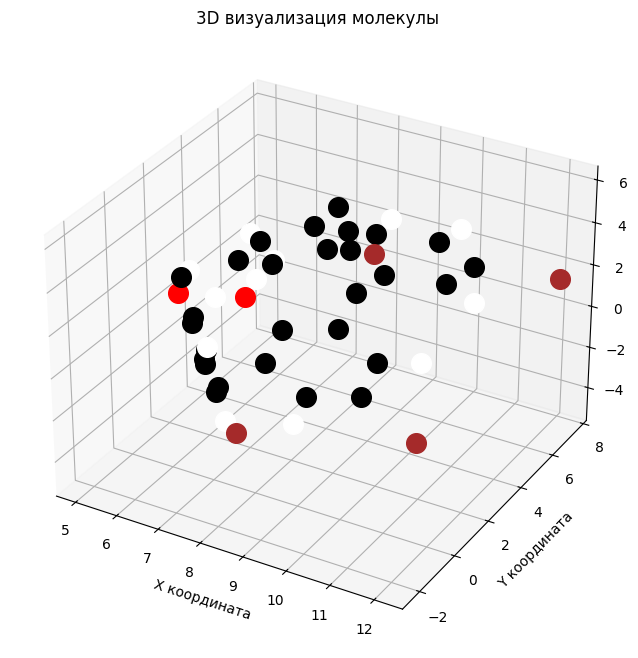

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Стандартные цвета для атомов
atom_colors = {
    'H': 'white',      # Водород
    'C': 'black',      # Углерод
    'N': 'blue',       # Азот
    'O': 'red',        # Кислород
    'S': 'yellow',     # Сера
    'P': 'orange',     # Фосфор
    'F': 'green',      # Фтор
    'Cl': 'green',     # Хлор
    'Br': 'brown',     # Бром
    'I': 'purple',     # Йод
    # Добавьте другие элементы по необходимости
}

def read_coordinates(filename):
    atoms = []
    coords = []
    with open(filename, 'r') as file:
        next(file)  # Пропустить первую строку
        next(file)  # Пропустить вторую строку
        for line in file:
            parts = line.strip().split()
            atoms.append(parts[0])
            coords.append([float(x) for x in parts[1:4]])
    return atoms, np.array(coords)

# Чтение данных
filename = '2.txt'  # Замените на имя вашего файла
atoms, coords = read_coordinates(filename)

# Создание 3D-фигуры
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Отображение атомов
for atom, coord in zip(atoms, coords):
    color = atom_colors.get(atom, 'grey')  # Серый цвет по умолчанию
    ax.scatter(coord[0], coord[1], coord[2], color=color, s=200)

# Настройка осей
ax.set_xlabel('X координата')
ax.set_ylabel('Y координата')
ax.set_zlabel('Z координата')
ax.set_title('3D визуализация молекулы')

# Добавление легенды
from matplotlib.lines import Line2D

# Удаляем дубликаты элементов для легенды
unique_atoms = set(atoms)
legend_elements = []
for element in unique_atoms:
    color = atom_colors.get(element, 'grey')
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=element,
                                  markerfacecolor=color, markersize=10))

plt.show()


# ШАГ 2. Визуализация вандерваальсовых радиусов

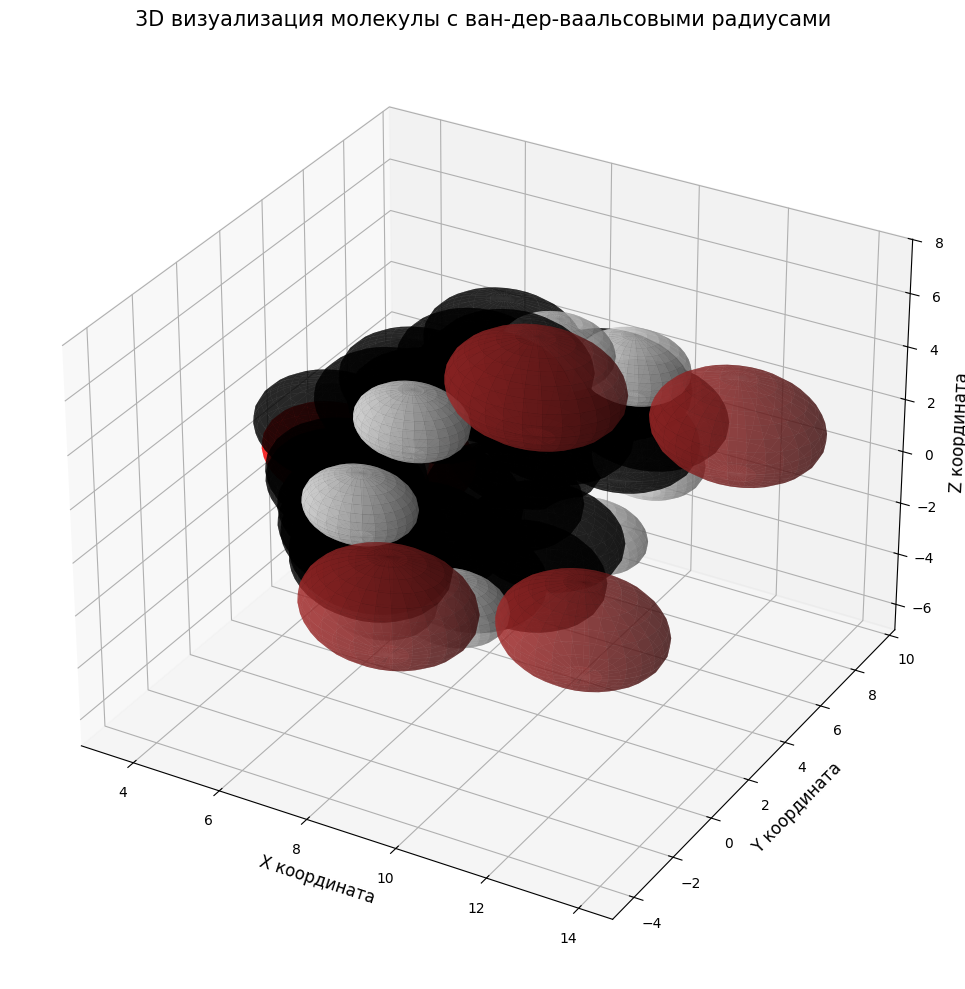

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Стандартные цвета для атомов (можно использовать HEX-коды для более точных цветов)
atom_colors = {
    'H': '#FFFFFF',      # Водород - белый
    'C': '#000000',      # Углерод - черный
    'N': '#0000FF',      # Азот - синий
    'O': '#FF0000',      # Кислород - красный
    'S': '#FFFF00',      # Сера - желтый
    'P': '#FFA500',      # Фосфор - оранжевый
    'F': '#00FF00',      # Фтор - зеленый
    'Cl': '#00FF00',     # Хлор - зеленый
    'Br': '#A52A2A',     # Бром - коричневый
    'I': '#800080',      # Йод - фиолетовый
    # Добавьте другие элементы по необходимости
}

# Словарь ван-дер-ваальсовых радиусов (в ангстремах)
vdw_radii = {
    'H': 1.20,
    'C': 1.70,
    'N': 1.55,
    'O': 1.52,
    'S': 1.80,
    'P': 1.80,
    'F': 1.47,
    'Cl': 1.75,
    'Br': 1.85,
    'I': 1.98,
    # Добавьте другие элементы по необходимости
}


# Чтение данных
filename = '2.txt'  # Замените на имя вашего файла
atoms, coords = read_coordinates(filename)



# Создание 3D-фигуры
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Отображение атомов в виде сфер с учетом ван-дер-ваальсовых радиусов
for atom, coord in zip(atoms, coords):
    color = atom_colors.get(atom, '#808080')  # Серый цвет по умолчанию
    radius = vdw_radii.get(atom, 1.5)  # Используем 1.5 Å по умолчанию
    # Создаем сферу
    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:15j]
    x = radius * np.cos(u) * np.sin(v) + coord[0]
    y = radius * np.sin(u) * np.sin(v) + coord[1]
    z = radius * np.cos(v) + coord[2]
    ax.plot_surface(x, y, z, color=color, linewidth=0, antialiased=True, shade=True, alpha=0.6)

# Настройка осей
ax.set_xlabel('X координата', fontsize=12)
ax.set_ylabel('Y координата', fontsize=12)
ax.set_zlabel('Z координата', fontsize=12)
ax.set_title('3D визуализация молекулы с ван-дер-ваальсовыми радиусами', fontsize=15)

# Настройка внешнего вида
ax.set_facecolor('white')
# ax.grid(False)
# ax.view_init(elev=30, azim=30)  # Установка угла обзора

# Добавление легенды
from matplotlib.lines import Line2D

unique_atoms = set(atoms)
legend_elements = []
for element in unique_atoms:
    color = atom_colors.get(element, '#808080')
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=element,
                                  markerfacecolor=color, markersize=10))


plt.tight_layout()
plt.show()


# ШАГ 2. Конвекс холл

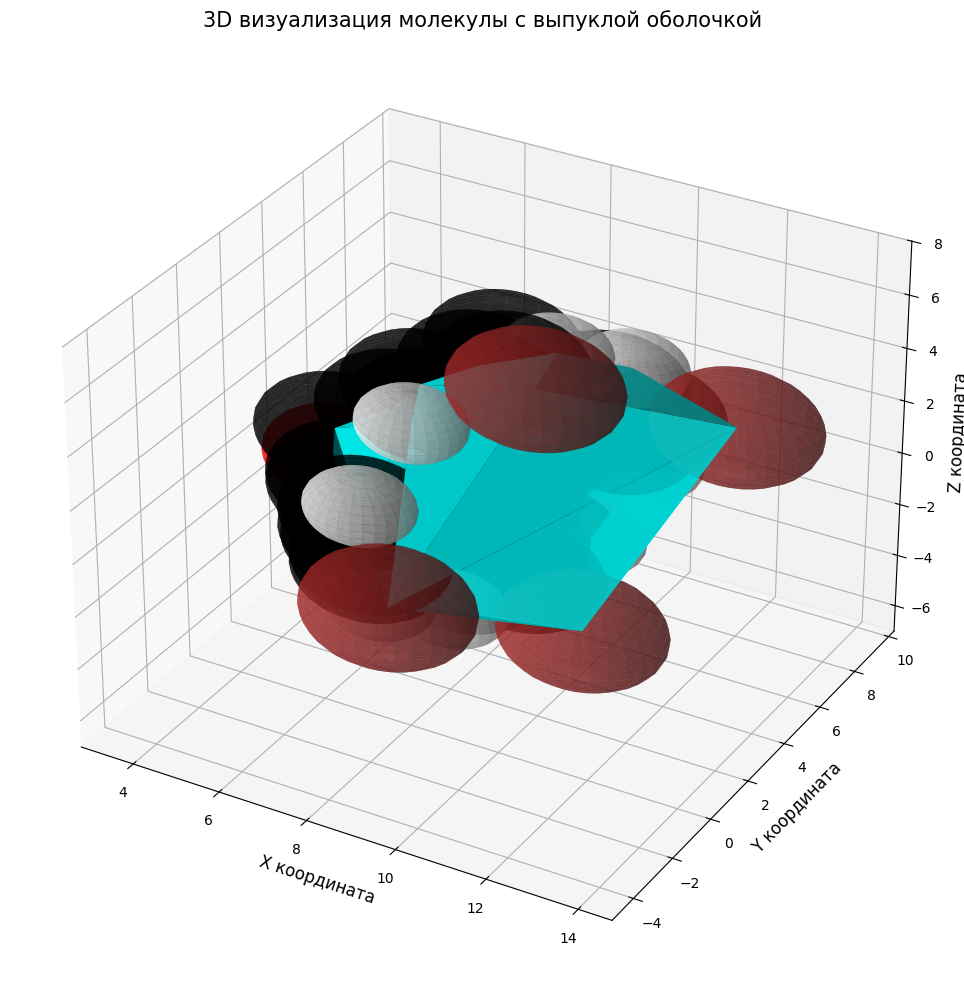

In [99]:
# Создание 3D-фигуры
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Отображение атомов в виде сфер с учетом ван-дер-ваальсовых радиусов
for atom, coord in zip(atoms, coords):
    color = atom_colors.get(atom, '#808080')  # Серый цвет по умолчанию
    radius = vdw_radii.get(atom, 1.5)  # Используем 1.5 Å по умолчанию
    # Создаем сферу
    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:15j]
    x = radius * np.cos(u) * np.sin(v) + coord[0]
    y = radius * np.sin(u) * np.sin(v) + coord[1]
    z = radius * np.cos(v) + coord[2]
    ax.plot_surface(x, y, z, color=color, linewidth=0, antialiased=True, shade=True, alpha=0.6)


hull = ConvexHull(coords)
hull_points = coords[hull.vertices]

max_radius = max(vdw_radii.values())
min_coords = np.min(hull_points, axis=0) - max_radius
max_coords = np.max(hull_points, axis=0) + max_radius

# Отображение выпуклой оболочки
# Получаем координаты вершин выпуклой оболочки
hull_vertices = coords[hull.vertices]

# Рисуем грани выпуклой оболочки
for simplex in hull.simplices:
    triangle = coords[simplex]
    x = triangle[:, 0]
    y = triangle[:, 1]
    z = triangle[:, 2]
    # Создаем массивы для замкнутого треугольника
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    z = np.append(z, z[0])
    ax.plot_trisurf(x, y, z, color='cyan', alpha=0.9, linewidth=0)

# Настройка осей
ax.set_xlabel('X координата', fontsize=12)
ax.set_ylabel('Y координата', fontsize=12)
ax.set_zlabel('Z координата', fontsize=12)
ax.set_title('3D визуализация молекулы с выпуклой оболочкой', fontsize=15)

# Настройка внешнего вида
ax.set_facecolor('white')

# Добавление легенды
from matplotlib.lines import Line2D

unique_atoms = set(atoms)
legend_elements = []
for element in unique_atoms:
    color = atom_colors.get(element, '#808080')
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=element,
                                  markerfacecolor=color, markersize=10))


plt.tight_layout()
plt.show()


# ШАГ 3. Создание 3D сетки точек, покрывающую молекулу

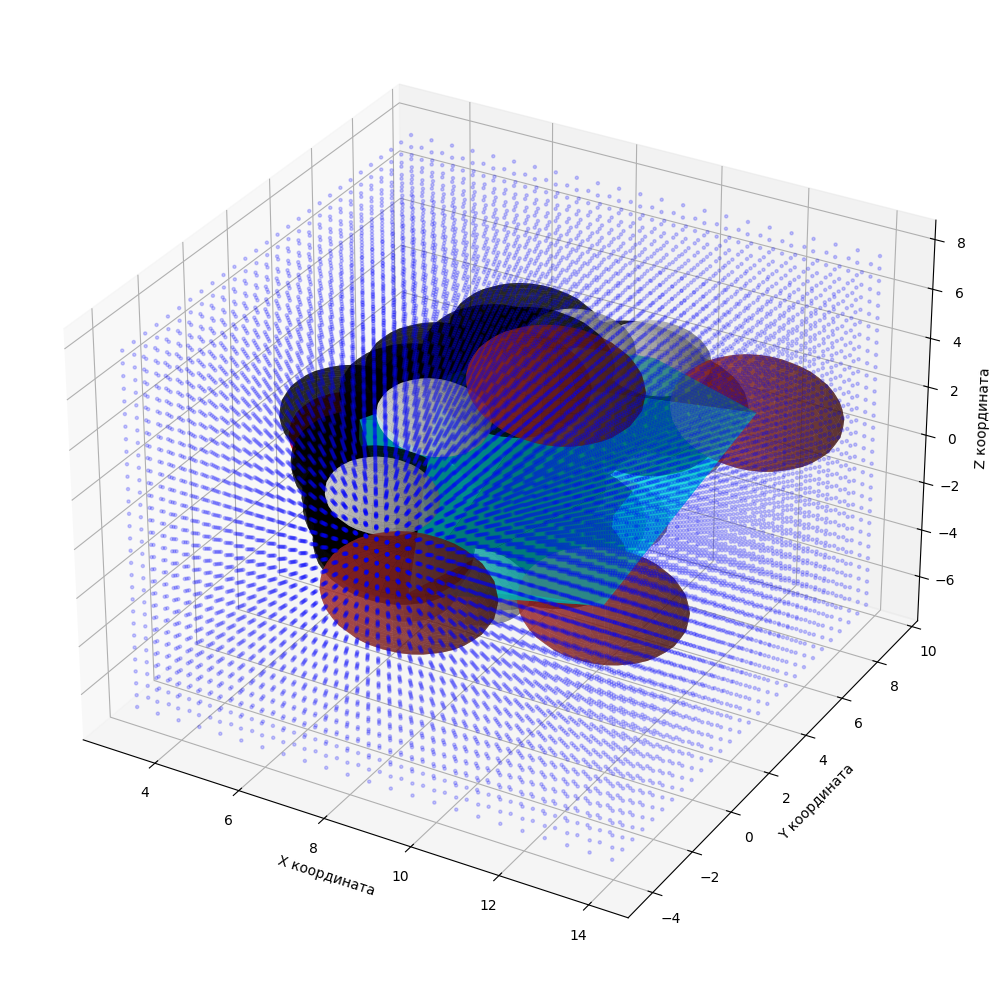

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

def visualize_up_to_delaunay(filename, azim=45, elev=30, grid_resolution=0.5):
    atoms, coords = read_coordinates(filename)
    atom_radii = np.array([vdw_radii.get(atom, 1.5) for atom in atoms])

    # Вычисление выпуклой оболочки
    hull = ConvexHull(coords)
    hull_points = coords[hull.vertices]

    # Определение границ сетки
    max_radius = max(vdw_radii.values())
    min_coords = np.min(hull_points, axis=0) - max_radius
    max_coords = np.max(hull_points, axis=0) + max_radius

    # Создание сетки точек
    x = np.arange(min_coords[0], max_coords[0], grid_resolution)
    y = np.arange(min_coords[1], max_coords[1], grid_resolution)
    z = np.arange(min_coords[2], max_coords[2], grid_resolution)
    X, Y, Z = np.meshgrid(x, y, z)
    grid_points = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T

    # Визуализация
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Отображение сетки точек
    ax.scatter(grid_points[:, 0], grid_points[:, 1], grid_points[:, 2],
               color='blue', s=5, alpha=0.2, label='Сетка точек')

    # Отображение атомов
    for atom, coord in zip(atoms, coords):
        color = atom_colors.get(atom, '#808080')  # Серый цвет по умолчанию
        radius = vdw_radii.get(atom, 1.5)  # Используем 1.5 Å по умолчанию
        # Создаем сферу
        u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:15j]
        x = radius * np.cos(u) * np.sin(v) + coord[0]
        y = radius * np.sin(u) * np.sin(v) + coord[1]
        z = radius * np.cos(v) + coord[2]
        ax.plot_surface(x, y, z, color=color, linewidth=0, antialiased=True, shade=True, alpha=0.6)

    # Отображение выпуклой оболочки
    for simplex in hull.simplices:
        triangle = coords[simplex]
        x_triangle = triangle[:, 0]
        y_triangle = triangle[:, 1]
        z_triangle = triangle[:, 2]
        ax.plot_trisurf(x_triangle, y_triangle, z_triangle, color='cyan', alpha=0.6)

    # Настройка осей и отображения
    ax.set_xlabel('X координата')
    ax.set_ylabel('Y координата')
    ax.set_zlabel('Z координата')

    plt.tight_layout()
    plt.show()

# Пример использования функции
filename = '2.txt'  # Замените на имя вашего файла
visualize_up_to_delaunay(filename)


# ШАГ 4. Определение точек внутри выпуклой оболочки c помощью триангуляции Деллоне

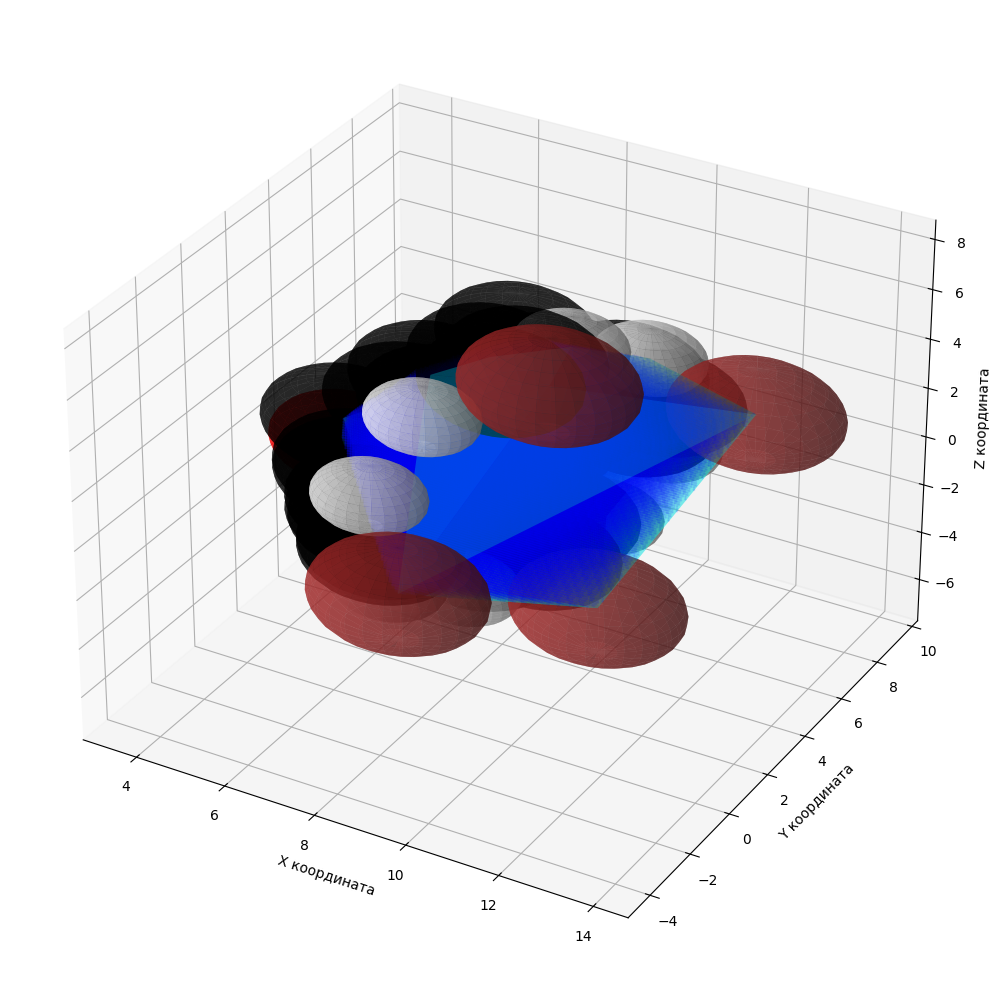

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, Delaunay


def visualize_up_to_tree(filename, azim=45, elev=30, grid_resolution=0.1):
    atoms, coords = read_coordinates(filename)
    atom_radii = np.array([vdw_radii.get(atom, 1.5) for atom in atoms])

    # Вычисление выпуклой оболочки
    hull = ConvexHull(coords)
    hull_points = coords[hull.vertices]

    # Определение границ сетки
    max_radius = max(vdw_radii.values())
    min_coords = np.min(hull_points, axis=0) - max_radius
    max_coords = np.max(hull_points, axis=0) + max_radius

    # Создание сетки точек
    x = np.arange(min_coords[0], max_coords[0], grid_resolution)
    y = np.arange(min_coords[1], max_coords[1], grid_resolution)
    z = np.arange(min_coords[2], max_coords[2], grid_resolution)
    X, Y, Z = np.meshgrid(x, y, z)
    grid_points = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T

    # Определение точек внутри выпуклой оболочки
    delaunay = Delaunay(hull_points)
    inside_hull = delaunay.find_simplex(grid_points) >= 0
    points_in_hull = grid_points[inside_hull]

    # Визуализация
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Отображение атомов
    for atom, coord in zip(atoms, coords):
        color = atom_colors.get(atom, '#808080')  # Серый цвет по умолчанию
        radius = vdw_radii.get(atom, 1.5)  # Используем 1.5 Å по умолчанию
        # Создаем сферу
        u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:15j]
        x = radius * np.cos(u) * np.sin(v) + coord[0]
        y = radius * np.sin(u) * np.sin(v) + coord[1]
        z = radius * np.cos(v) + coord[2]
        ax.plot_surface(x, y, z, color=color, linewidth=0, antialiased=True, shade=True, alpha=0.6)


    # Отображение выпуклой оболочки
    for simplex in hull.simplices:
        triangle = coords[simplex]
        x_triangle = triangle[:, 0]
        y_triangle = triangle[:, 1]
        z_triangle = triangle[:, 2]
        ax.plot_trisurf(x_triangle, y_triangle, z_triangle, color='cyan', alpha=0.3)

    # Отображение точек внутри выпуклой оболочки
    ax.scatter(points_in_hull[:, 0], points_in_hull[:, 1], points_in_hull[:, 2],
               color='blue', s=1, alpha=0.1, label='Сетка точек')

    # Настройка осей и отображения
    ax.set_xlabel('X координата')
    ax.set_ylabel('Y координата')
    ax.set_zlabel('Z координата')

    plt.tight_layout()
    plt.show()

# Пример использования функции
filename = '2.txt'  # Замените на имя вашего файла
visualize_up_to_tree(filename)


# ШАГ 5. Поиск точек внутри атомов

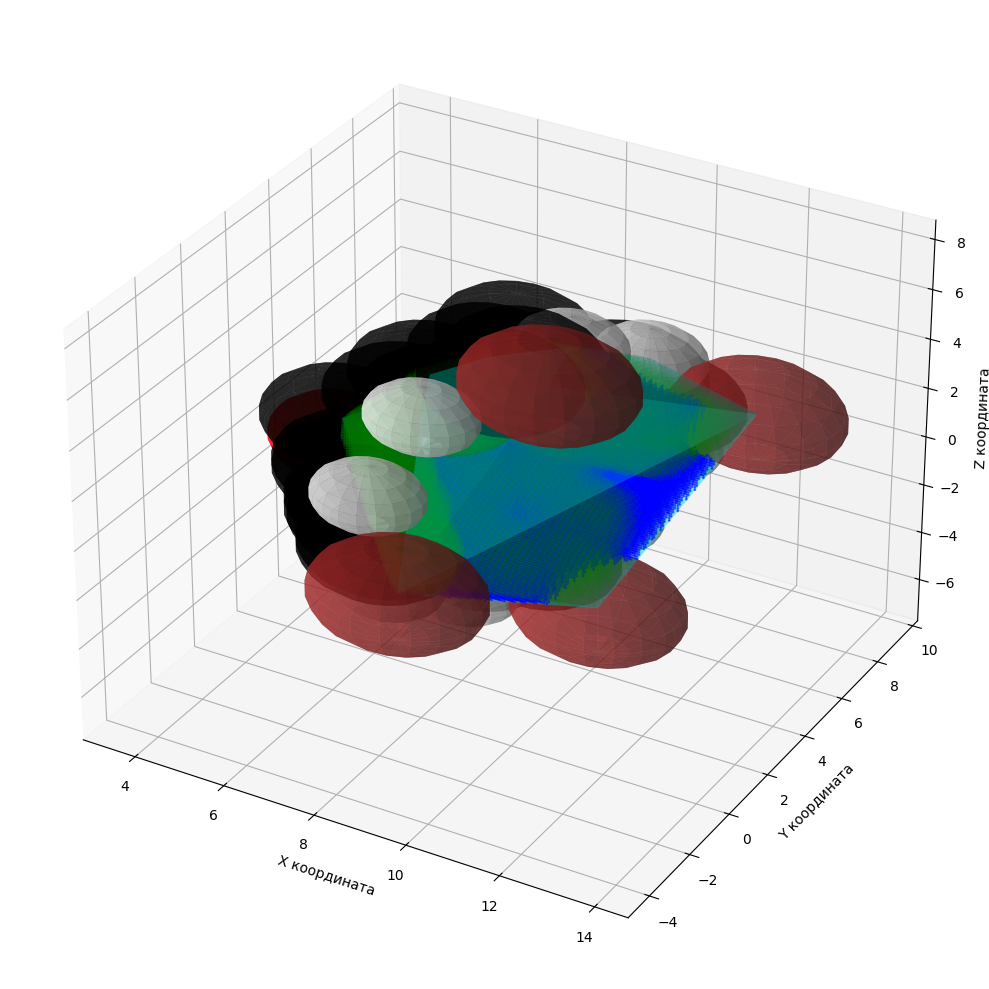

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, Delaunay, cKDTree

def visualize_from_delaunay_to_volume(filename, azim=45, elev=30, grid_resolution=0.1):
    atoms, coords = read_coordinates(filename)
    atom_radii = np.array([vdw_radii.get(atom, 1.5) for atom in atoms])

    hull = ConvexHull(coords)
    hull_points = coords[hull.vertices]

    max_radius = max(vdw_radii.values())
    min_coords = np.min(hull_points, axis=0) - max_radius
    max_coords = np.max(hull_points, axis=0) + max_radius

    x = np.arange(min_coords[0], max_coords[0], grid_resolution)
    y = np.arange(min_coords[1], max_coords[1], grid_resolution)
    z = np.arange(min_coords[2], max_coords[2], grid_resolution)
    X, Y, Z = np.meshgrid(x, y, z)
    grid_points = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T

    # Delaunay триангуляция
    delaunay = Delaunay(hull_points)

    # Определение точек внутри выпуклой оболочки
    inside_hull = delaunay.find_simplex(grid_points) >= 0
    points_in_hull = grid_points[inside_hull]

    # Построение KD-дерева для эффективного поиска соседей
    tree = cKDTree(coords)
    max_atom_radius = max(atom_radii)
    indices = tree.query_ball_point(points_in_hull, r=max_atom_radius)
    inside_atom = np.zeros(len(points_in_hull), dtype=bool)

    # Определение точек внутри атомов
    for i, inds in enumerate(indices):
        point = points_in_hull[i]
        for j in inds:
            distance = np.linalg.norm(point - coords[j])
            if distance <= atom_radii[j]:
                inside_atom[i] = True
                break

    # Вычисление объёмов
    volume_total = hull.volume
    volume_atom = np.sum(inside_atom) * (grid_resolution ** 3)
    volume_cavity = np.sum(~inside_atom) * (grid_resolution ** 3)

    # Визуализация
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Точки в полостях (синие)
    ax.scatter(points_in_hull[~inside_atom, 0], points_in_hull[~inside_atom, 1], points_in_hull[~inside_atom, 2],
               color='blue', s=1, alpha=0.5, label='Точки в полостях')

    # Точки внутри атомов (зелёные)
    ax.scatter(points_in_hull[inside_atom, 0], points_in_hull[inside_atom, 1], points_in_hull[inside_atom, 2],
               color='green', s=1, alpha=0.1, label='Точки внутри атомов')

    # Отображение атомов
    for atom, coord in zip(atoms, coords):
        color = atom_colors.get(atom, '#808080')  # Серый цвет по умолчанию
        radius = vdw_radii.get(atom, 1.5)
        # Создаем сферу для каждого атома
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x_sphere = radius * np.cos(u) * np.sin(v) + coord[0]
        y_sphere = radius * np.sin(u) * np.sin(v) + coord[1]
        z_sphere = radius * np.cos(v) + coord[2]
        ax.plot_surface(x_sphere, y_sphere, z_sphere, color=color, alpha=0.6)

    # Отображение выпуклой оболочки
    for simplex in hull.simplices:
        triangle = coords[simplex]
        x_triangle = triangle[:, 0]
        y_triangle = triangle[:, 1]
        z_triangle = triangle[:, 2]
        ax.plot_trisurf(x_triangle, y_triangle, z_triangle, color='cyan', alpha=0.3)

    # Настройка осей и отображения
    ax.set_xlabel('X координата')
    ax.set_ylabel('Y координата')
    ax.set_zlabel('Z координата')

    # Добавление легенды

    plt.tight_layout()
    plt.show()

    return (volume_total, volume_atom, volume_cavity)

# Пример использования функции
filename = '2.txt'  # Замените на имя вашего файла
volume_total, volume_atom, volume_cavity = visualize_from_delaunay_to_volume(filename)
